<a href="https://colab.research.google.com/github/lab-jianghao/spark_ml_sample/blob/main/08_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-17-jdk-headless

!wget https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz /content
!tar xf spark-3.5.0-bin-hadoop3.tgz

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
!pip install pyspark==3.5.0

In [4]:
from functools import wraps
from pyspark.sql import SparkSession

def spark_sql_initializer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):

        spark = SparkSession.builder\
            .appName("Colab_SPARK_ML")\
            .master("local[*]")\
            .getOrCreate()

        spark.sparkContext.setLogLevel("WARN")

        func(spark,*args, **kwargs)

        spark.stop()

    return wrapper

In [5]:
import seaborn as sns

diamonds_df = sns.load_dataset("diamonds")
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


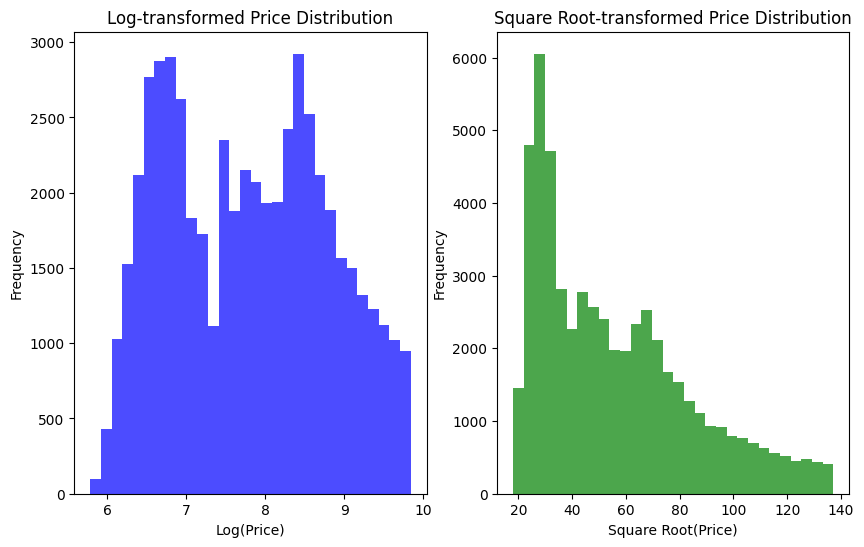

In [6]:
import numpy as np
import matplotlib.pyplot as plt

prices = diamonds_df['price']

log_prices = np.log(prices)
sqrt_prices = np.sqrt(prices)

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.hist(log_prices, bins=30, color='blue', alpha=0.7)
plt.title('Log-transformed Price Distribution')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(sqrt_prices, bins=30, color='green', alpha=0.7)
plt.title('Square Root-transformed Price Distribution')
plt.xlabel('Square Root(Price)')
plt.ylabel('Frequency')

plt.show()


In [7]:
from pyspark.ml import Pipeline

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.functions import log, col, exp

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

@spark_sql_initializer
def train_log_tuned_RF(spark, df, num_trees=50, max_depth=10):
    diamonds_df = spark.createDataFrame(df)
    diamonds_df.show()

    index_columns = ['cut', 'color', 'clarity']
    diamonds_df = diamonds_df.withColumn("label", log(col("price") + 1))

    feature_indexes = [StringIndexer(inputCol=col, outputCol=f"indexed_{col}", handleInvalid="keep") for col in index_columns]
    for indexer in feature_indexes:
        diamonds_df = indexer.fit(diamonds_df).transform(diamonds_df)

    feature_encoders = [OneHotEncoder(inputCol=f"indexed_{col}", outputCol=f"encoded_{col}") for col in index_columns]
    for encoder in feature_encoders:
        diamonds_df = encoder.fit(diamonds_df).transform(diamonds_df)
    diamonds_df = diamonds_df.drop(*list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)))

    feature_columns = [col for col in diamonds_df.columns if col not in index_columns + ['label', 'price']]

    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    # diamonds_df = vector_assembler.transform(diamonds_df)
    diamonds_df = diamonds_df.drop(*list(map(lambda idx_col: f"encoded_{idx_col}", index_columns)))

    rf = RandomForestRegressor(featuresCol="features", labelCol="label", predictionCol="prediction")

    param_grid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [num_trees * i for i in range(1, 3)]) \
        .addGrid(rf.maxDepth, [max_depth * i for i in range(1, 2)]) \
        .build()

    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

    rf_pipeline = Pipeline(stages=feature_indexes + feature_encoders + [vector_assembler, rf])

    cross_val = CrossValidator(estimator=rf_pipeline,
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=3)
    cv_model = cross_val.fit(diamonds_df)

    best_model = cv_model.bestModel
    best_params = best_model.stages[-1].extractParamMap()

    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param.name}: {value}")

    best_model.write().overwrite().save("file:///content/model/log_tuned")


In [8]:
train_log_tuned_RF(diamonds_df.copy())

+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
|  0.3|     Good|    J|    SI1| 64.0| 55.0|  339|4.25|4.28|2.73|
| 0.23|    Ideal|    J|    VS1| 62.8| 56.0|  340|3.93| 3.9|2.46|
| 0.22|  Premium|    F|  

In [9]:
from pyspark.ml import PipelineModel, Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

@spark_sql_initializer
def test_log_model(spark, df):

    diamonds_df = spark.createDataFrame(df)
    training_data, test_data = diamonds_df.randomSplit([0.7, 0.3], seed=1000)

    loaded_model = PipelineModel.load("file:///content/model/tuned")

    test_prediction = loaded_model.transform(test_data)
    test_prediction = test_prediction.withColumn("predicted_price", exp("prediction") - 1)

    evaluator = RegressionEvaluator(labelCol="price", predictionCol="predicted_price", metricName="rmse")
    test_rmse = evaluator.evaluate(test_prediction)
    print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(test_rmse))

    test_prediction.select("price", "predicted_price").show()


In [10]:
test_log_model(diamonds_df.copy())

Root Mean Squared Error (RMSE) on test data = 801.19
+-----+------------------+
|price|   predicted_price|
+-----+------------------+
|  404|431.78234022709984|
|  402| 442.6217477476472|
|  402|445.26357826544165|
|  423|  487.950893271761|
|  404|483.09890825481114|
|  640| 582.9021590723501|
|  640| 607.3786417832573|
|  611| 440.7079602105078|
|  402| 440.7269821351698|
|  357| 442.6625777870821|
|  600| 541.7943662298848|
|  583| 543.4536039337073|
|  583| 543.4536039337073|
|  414| 531.2520671153693|
|  417|483.14233702831604|
|  559| 587.8320681040449|
|  559| 589.5792402810143|
|  559| 587.4081206056726|
|  559| 587.4081206056726|
|  559| 587.4081206056726|
+-----+------------------+
only showing top 20 rows



In [14]:
from pyspark.ml import Pipeline

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.functions import log, col, exp

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

@spark_sql_initializer
def train_tuned_RF(spark, df, num_trees=50, max_depth=10):
    diamonds_df = spark.createDataFrame(df)
    diamonds_df.show()

    index_columns = ['cut', 'color', 'clarity']
    diamonds_df = diamonds_df.withColumnRenamed("price", "label")

    feature_indexes = [StringIndexer(inputCol=col, outputCol=f"indexed_{col}", handleInvalid="keep") for col in index_columns]
    for indexer in feature_indexes:
        diamonds_df = indexer.fit(diamonds_df).transform(diamonds_df)

    feature_encoders = [OneHotEncoder(inputCol=f"indexed_{col}", outputCol=f"encoded_{col}") for col in index_columns]
    for encoder in feature_encoders:
        diamonds_df = encoder.fit(diamonds_df).transform(diamonds_df)
    diamonds_df = diamonds_df.drop(*list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)))

    feature_columns = [col for col in diamonds_df.columns if col not in index_columns + ['label']]

    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    # diamonds_df = vector_assembler.transform(diamonds_df)
    diamonds_df = diamonds_df.drop(*list(map(lambda idx_col: f"encoded_{idx_col}", index_columns)))

    rf = RandomForestRegressor(featuresCol="features", labelCol="label", predictionCol="prediction")

    param_grid = ParamGridBuilder() \
        .addGrid(rf.numTrees, [num_trees * i for i in range(1, 3)]) \
        .addGrid(rf.maxDepth, [max_depth * i for i in range(1, 2)]) \
        .build()

    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

    rf_pipeline = Pipeline(stages=feature_indexes + feature_encoders + [vector_assembler, rf])

    cross_val = CrossValidator(estimator=rf_pipeline,
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=3)
    cv_model = cross_val.fit(diamonds_df)

    best_model = cv_model.bestModel
    best_params = best_model.stages[-1].extractParamMap()

    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param.name}: {value}")

    best_model.write().overwrite().save("file:///content/model/tuned")


In [15]:
train_tuned_RF(diamonds_df.copy())

+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
|  0.3|     Good|    J|    SI1| 64.0| 55.0|  339|4.25|4.28|2.73|
| 0.23|    Ideal|    J|    VS1| 62.8| 56.0|  340|3.93| 3.9|2.46|
| 0.22|  Premium|    F|  

In [20]:
from pyspark.ml import PipelineModel, Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

@spark_sql_initializer
def test_model(spark, df):

    diamonds_df = spark.createDataFrame(df)
    training_data, test_data = diamonds_df.randomSplit([0.7, 0.3], seed=1000)

    loaded_model = PipelineModel.load("file:///content/model/tuned")

    test_prediction = loaded_model.transform(test_data)

    evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
    test_rmse = evaluator.evaluate(test_prediction)
    print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(test_rmse))

    test_prediction.select("price", "prediction").show()


In [21]:
test_model(diamonds_df.copy())

Root Mean Squared Error (RMSE) on test data = 709.85
+-----+------------------+
|price|        prediction|
+-----+------------------+
|  404|485.55022832829104|
|  402|488.93924491073943|
|  402|491.29612039319613|
|  423|502.88631937075013|
|  404| 503.2119291787748|
|  640| 582.2784286231913|
|  640| 594.6333515195372|
|  611| 480.7816399967399|
|  402|480.50483444118436|
|  357| 479.5490131253228|
|  600| 543.0635265328171|
|  583| 546.9698391604752|
|  583| 546.9698391604752|
|  414| 538.9685308609078|
|  417|498.43571120573085|
|  559|  587.139748487712|
|  559| 592.3145551059496|
|  559|  588.994743505849|
|  559|  588.994743505849|
|  559|  588.994743505849|
+-----+------------------+
only showing top 20 rows



In [23]:
from pyspark.ml import Pipeline

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.functions import log, col, exp

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


@spark_sql_initializer
def train_tuned_GBT(spark, df, max_depth=5, max_iter=20):
    diamonds_df = spark.createDataFrame(df)
    diamonds_df.show()

    index_columns = ['cut', 'color', 'clarity']
    diamonds_df = diamonds_df.withColumnRenamed("price", "label")

    feature_indexes = [StringIndexer(inputCol=col, outputCol=f"indexed_{col}", handleInvalid="keep") for col in index_columns]
    for indexer in feature_indexes:
        diamonds_df = indexer.fit(diamonds_df).transform(diamonds_df)

    feature_encoders = [OneHotEncoder(inputCol=f"indexed_{col}", outputCol=f"encoded_{col}") for col in index_columns]
    for encoder in feature_encoders:
        diamonds_df = encoder.fit(diamonds_df).transform(diamonds_df)
    diamonds_df = diamonds_df.drop(*list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)))

    feature_columns = [col for col in diamonds_df.columns if col not in index_columns + ['label']]

    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    diamonds_df = diamonds_df.drop(*list(map(lambda idx_col: f"encoded_{idx_col}", index_columns)))

    gbt = GBTRegressor(featuresCol="features", labelCol="label", predictionCol="prediction")

    param_grid = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [max_depth * i for i in range(1, 3)]) \
        .addGrid(gbt.maxIter, [max_iter * i for i in range(1, 3)]) \
        .build()

    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

    gbt_pipeline = Pipeline(stages=feature_indexes + feature_encoders + [vector_assembler, gbt])

    cross_val = CrossValidator(estimator=gbt_pipeline,
                               estimatorParamMaps=param_grid,
                               evaluator=evaluator,
                               numFolds=3)
    cv_model = cross_val.fit(diamonds_df)

    best_model = cv_model.bestModel
    best_params = best_model.stages[-1].extractParamMap()

    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param.name}: {value}")

    best_model.write().overwrite().save("file:///content/model/tuned")


In [24]:
train_tuned_GBT(diamonds_df.copy())

+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+---------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
|  0.3|     Good|    J|    SI1| 64.0| 55.0|  339|4.25|4.28|2.73|
| 0.23|    Ideal|    J|    VS1| 62.8| 56.0|  340|3.93| 3.9|2.46|
| 0.22|  Premium|    F|  

In [25]:
test_model(diamonds_df.copy())

Root Mean Squared Error (RMSE) on test data = 375.19
+-----+------------------+
|price|        prediction|
+-----+------------------+
|  404| 433.4775990516789|
|  402|409.87123483399387|
|  402| 348.8460418527563|
|  423| 524.0435075218908|
|  404|  439.038096449769|
|  640| 659.9624022855759|
|  640| 668.3325936564647|
|  611| 448.0136479108509|
|  402| 459.6024981669527|
|  357| 434.3643725556953|
|  600|   514.36828946368|
|  583| 576.0794934203266|
|  583| 576.0794934203266|
|  414|493.19784605967504|
|  417| 511.5079346685581|
|  559| 596.9580056478407|
|  559| 620.2022886702531|
|  559| 616.7862532871887|
|  559| 616.7862532871887|
|  559| 616.7862532871887|
+-----+------------------+
only showing top 20 rows

